In [94]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.PINNnet import PINN
#from utils.plot_func import plot_field, model_Apred, plot_error_field, plot_loss
from utils.plot_func import plot_field
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [95]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

In [96]:
import joblib
state_dict = joblib.load('model_green.joblib')
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [97]:
def green(x, y, src, device=device, is_tensor='True'):
    if is_tensor:
        r = torch.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        r = r.detach().to('cpu').numpy()
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g_real, g_imag = torch.tensor(g_real, dtype=torch.float32), torch.tensor(g_imag, dtype=torch.float32)
        g = torch.cat([g_real, g_imag], dim=-1).to(device)
    else:
        r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g = np.concatenate([g_real, g_imag], axis=-1)
    return g


In [98]:
model = model.to(device)

In [107]:
k = 2 * np.pi * 20 / 1500 *100
def model_pred(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-0.7, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    g = green(x, y, [-0.4, 0.5], is_tensor=False)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N) + g[:,0:1].reshape(N, N), p_imag.reshape(N, N) + g[:,1:2].reshape(N, N)

    x, y = (x+0.7) * 100, (y-1) * 100
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Half-space (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Half-space (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('Half-space.jpg')
    

/tmp/ipykernel_40926/274209676.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
/tmp/ipykernel_40926/274209676.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hankel = scipy.special.hankel2(0, k * r + 1e-6)


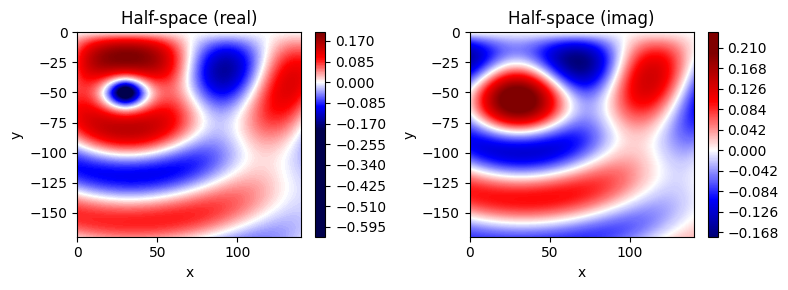

In [108]:
model_pred(model, 0.7, 1)

In [101]:
# fixed parameters
L = 1
Lx, Ly = L, L
src = [-0.4, 0.5]
k = 2 * np.pi * 20 / 1500 * 100

In [102]:
import scipy
x, y = np.linspace(-0.7, 0.7, 200), np.linspace(-0.7, 1, 200)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

hankel = scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-0.5) ** 2))-scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-1.5) ** 2))
field = 0.25j * hankel
field = field.reshape(200, 200)
p_ref = field

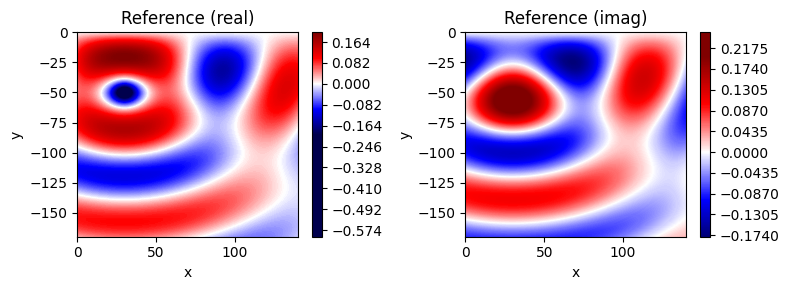

In [103]:
plot_field(field, [0, 140], [-170, 0], bar_max=0.2, title='Reference', filename='Reference')

In [104]:
k = 2 * np.pi * 20 / 1500 *100
def model_pred(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-0.7, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    g = green(x, y, [-0.4, 1.5], is_tensor=False)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N) + g[:,0:1].reshape(N, N), p_imag.reshape(N, N) + g[:,1:2].reshape(N, N)
    #p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)
    x, y = (x+0.7) * 100, (y-1) * 100
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Error (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Error (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.savefig('Error.jpg')
    print(f'real loss: {p_real.mean()/g[:,0:1].mean()}, imag loss: {p_imag.mean()/g[:,1:2].mean()}')

/tmp/ipykernel_40926/274209676.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
/tmp/ipykernel_40926/274209676.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hankel = scipy.special.hankel2(0, k * r + 1e-6)


real loss: 0.05919301509857178, imag loss: -0.10956534743309021


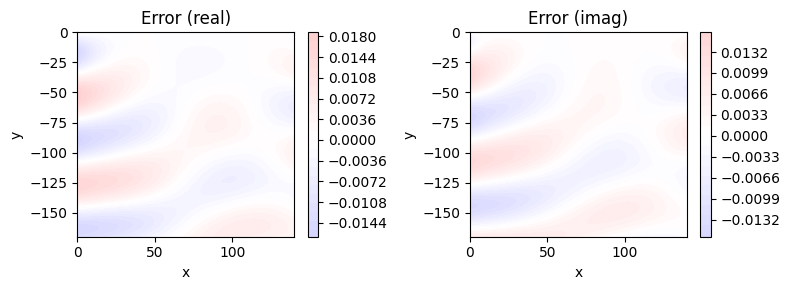

In [105]:
model_pred(model, 0.7, 1)